## Setup environment

In [25]:

from monai.utils import first, set_determinism
import torch
import matplotlib.pyplot as plt
import os
from UNet_model import create_unet
import torch.nn as nn
from data_preparation2 import DataHandling 
from datetime import datetime
import json
import numpy as np


In [38]:
data_dir = '/home/shahpouriz/Data/Practic/ASC-PET-001'
directory = '/home/shahpouriz/Data/Practic/LOG'
output_dir = '/home/shahpouriz/Data/Practic/OUT'
log_filename = 'log_1_24_15_44.txt'
log_filepath = directory + '/'+ log_filename

## Set dataset path

In [27]:
# Function to read JSON config file
def read_config(config_path):
    with open(config_path, 'r') as config_file:
        return json.load(config_file)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



print("Starting preparing data ...")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

config_path = "/home/shahpouriz/Data/Practic/training_params.json"
config = read_config(config_path)

data_prep = DataHandling(config)
loaders, _, _ = data_prep.prepare_data(loaders_to_prepare=["val", "test"])
val_loader = loaders.get("val")
test_loader = loaders.get("test")
model = create_unet().to(device)


Starting preparing data ...
Loading data from: /home/shahpouriz/Data/Practic/ASC-PET-001
Total images loaded: 184


Loading dataset: 100%|██████████| 40/40 [00:51<00:00,  1.28s/it]


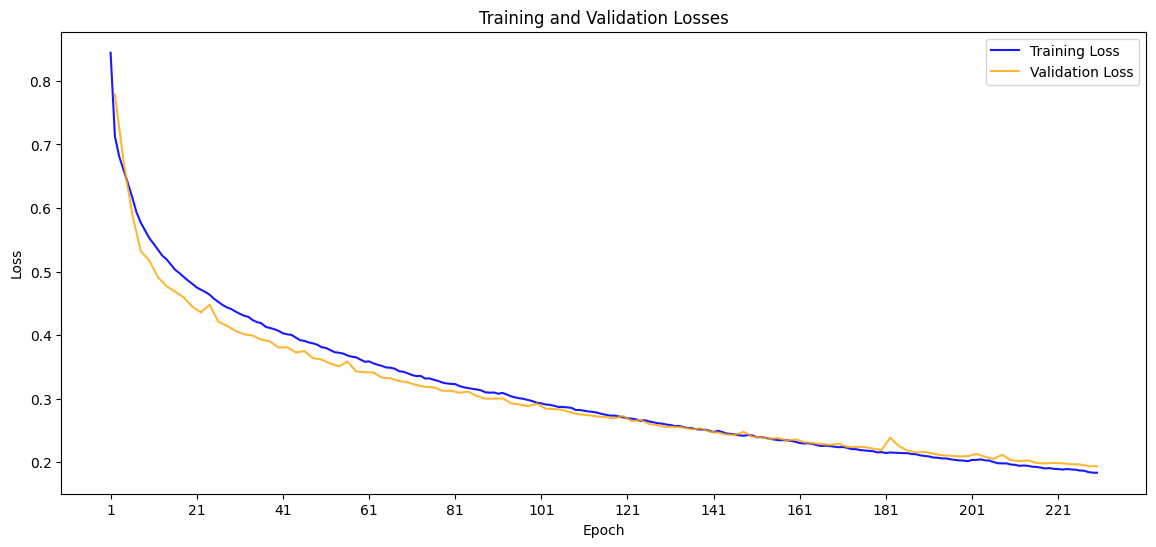

In [28]:

# Function to parse the loss values from the log file
def parse_loss_values(log_filepath):
    train_losses = []
    val_losses = []
    with open(log_filepath, 'r') as file:
        for line in file:
            if 'average loss:' in line:
                loss_value = float(line.split(': ')[-1])
                train_losses.append(loss_value)
            if 'Validation loss:' in line:
                val_loss_value = float(line.split(': ')[-1])
                val_losses.append(val_loss_value)
    return train_losses, val_losses


train_losses, val_losses = parse_loss_values(log_filepath)

max_epochs = len(train_losses)
val_interval = config['val_interval']

# Plotting

plt.figure(figsize=(14, 6))
plt.plot(range(1, max_epochs + 1), train_losses, label='Training Loss', color='blue', alpha=0.9)
plt.plot(range(2, max_epochs + 1, val_interval), val_losses, label='Validation Loss', color='orange', alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.xticks(np.arange(1, max_epochs + 1, 20))  # Adjust the x-axis ticks if needed
plt.show()


In [29]:
from utils import find_last_best_model

bestmodel_filename, best_metric, best_epoch = find_last_best_model(log_filepath)
print(f"Last Best Model Saved as: {bestmodel_filename}, Best Metric: {best_metric}, Epoch: {best_epoch}")


Last Best Model Saved as: model_1_24_18_48.pth, Best Metric: 0.1938, Epoch: 230


In [30]:
from utils import find_model_info
def load_model(directory, model_filename):
    model_path = os.path.join(directory, model_filename)
    if os.path.exists(model_path):
        print(f"Model file {model_filename} is loading.")
        # Load the model onto the CPU
        model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    else:
        print(f"Model file {model_filename} not found.")


# Usage
model_filename_to_find = bestmodel_filename
# model_filename_to_find = 'model_1_23_21_10.pth'

load_model(directory, model_filename_to_find)

bestmodel_filename, best_metric, best_epoch = find_model_info(log_filepath, model_filename_to_find)
print(f"Model: {bestmodel_filename}, Best Metric: {best_metric}, Epoch: {best_epoch}")

Model file model_1_24_18_48.pth is loading.
Model: model_1_24_18_48.pth, Best Metric: 0.1938, Epoch: 230


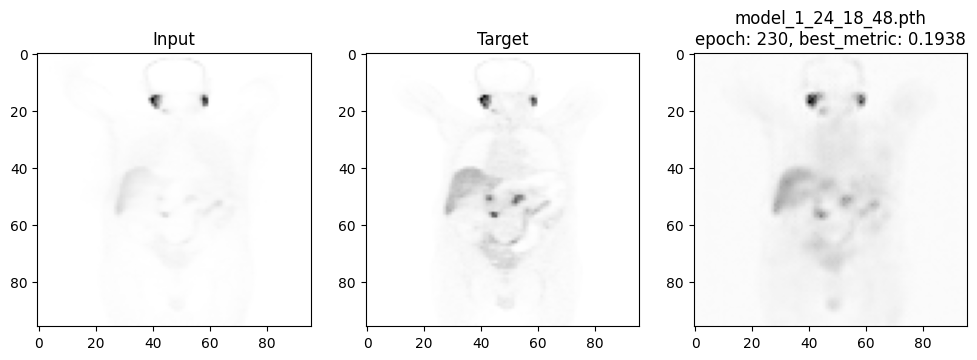

In [36]:
def visualize_results_whole(val_data, model, n, title):
    model.eval()
    with torch.no_grad():
        val_outputs = model(val_data["image"].to(device))

    plt.figure("check", (12, 6))

    plt.subplot(1, 3, 1)
    plt.title(f"Input")
    input_slice = np.rot90(val_data["image"][0, 0, :, n, :])
    plt.imshow(input_slice, cmap="gist_yarg")

    plt.subplot(1, 3, 2)
    plt.title(f"Target")
    target_slice = np.rot90(val_data["target"][0, 0, :, n, :])
    plt.imshow(target_slice, cmap="gist_yarg")

    plt.subplot(1, 3, 3)
    plt.title(title)
    output_slice = np.rot90(val_outputs.detach().cpu()[0, 0, :, n, :])
    plt.imshow(output_slice, cmap="gist_yarg")
    
    plt.show()

# Usage
with torch.no_grad():
    for i, val_data in enumerate(test_loader):
        n = 50
        visualize_results_whole(val_data, model, n, f"{bestmodel_filename}\nepoch: {best_epoch}, best_metric: {best_metric}")
        if i == 0:
            break


------------------
# Quantification Evaluation

In [32]:
import numpy as np
import torch
from skimage.metrics import structural_similarity as ssim
from math import log10, sqrt

def mean_error(predicted, reference):
    return np.mean(predicted - reference)

def mean_absolute_error(predicted, reference):
    return np.mean(np.abs(predicted - reference))

def relative_error(predicted, reference, epsilon=0.3):
    return np.mean((predicted - reference) / (reference + epsilon)) * 100

def absolute_relative_error(predicted, reference, epsilon=0.3):
    return np.mean(np.abs(predicted - reference) / (reference + epsilon)) * 100

def rmse(predicted, reference):
    return sqrt(np.mean((predicted - reference) ** 2))

def psnr(predicted, reference, peak):
    mse = np.mean((predicted - reference) ** 2)
    return 20 * log10(peak / sqrt(mse))

def calculate_ssim(predicted, reference):
    return ssim(predicted, reference, data_range=reference.max() - reference.min())


In [33]:
# import numpy as np

# def evaluate_metrics(data_loader, model, device):
#     sum_mean_error = sum_mae = sum_re = sum_are = sum_rmse = sum_psnr = sum_ssim = num_patients = 0

#     model.eval()
#     with torch.no_grad():
#         for data in data_loader:
#             inputs, targets = data["image"].to(device), data["target"].to(device)
#             outputs = model(inputs)

#             outputs_np = np.squeeze(outputs.cpu().numpy() * 5, axis=1)
#             targets_np = np.squeeze(targets.cpu().numpy() * 5, axis=1)

#             for output, target in zip(outputs_np, targets_np):
#                 peak = np.max([output.max(), target.max()])
#                 sum_mean_error += mean_error(output, target)
#                 sum_mae += mean_absolute_error(output, target)
#                 sum_re += relative_error(output, target)
#                 sum_are += absolute_relative_error(output, target)
#                 sum_rmse += rmse(output, target)
#                 sum_psnr += psnr(output, target, peak)
#                 sum_ssim += calculate_ssim(output, target)
#                 num_patients += 1

#     metrics = {
#         "mean_ME": sum_mean_error / num_patients,
#         "mean_MAE": sum_mae / num_patients,
#         "mean_RE%": sum_re / num_patients,
#         "mean_ARE%": sum_are / num_patients,
#         "mean_RMSE": sum_rmse / num_patients,
#         "mean_PSNR": sum_psnr / num_patients,
#         "mean_SSIM": sum_ssim / num_patients
#     }

#     return metrics


# val_metrics = evaluate_metrics(val_loader, model, device)
# print("Validation Metrics:")
# for metric, value in val_metrics.items():
#     print(f"{metric}: {value:.2f}")

# test_metrics = evaluate_metrics(test_loader, model, device)
# print("\nTest Metrics:")
# for metric, value in test_metrics.items():
#     print(f"{metric}: {value:.2f}")




Validation Metrics:
mean_ME: 0.00
mean_MAE: 0.33
mean_RE%: 1.22
mean_ARE%: 33.15
mean_RMSE: 2.22
mean_PSNR: 38.99
mean_SSIM: 0.98

Test Metrics:
mean_ME: -0.02
mean_MAE: 0.34
mean_RE%: 0.74
mean_ARE%: 33.29
mean_RMSE: 2.30
mean_PSNR: 38.54
mean_SSIM: 0.98


In [20]:
def evaluate_metrics(data_loader, model, device):
    metrics = {
        "mean_error": [],
        "mae": [],
        "re": [],
        "are": [],
        "rmse": [],
        "psnr": [],
        "ssim": []
    }

    model.eval()
    with torch.no_grad():
        for data in data_loader:
            inputs, targets = data["image"].to(device), data["target"].to(device)
            outputs = model(inputs)

            outputs_np = np.squeeze(outputs.cpu().numpy() * 5, axis=1)
            targets_np = np.squeeze(targets.cpu().numpy() * 5, axis=1)

            for output, target in zip(outputs_np, targets_np):
                peak = np.max([output.max(), target.max()])
                metrics["mean_error"].append(mean_error(output, target))
                metrics["mae"].append(mean_absolute_error(output, target))
                metrics["re"].append(relative_error(output, target))
                metrics["are"].append(absolute_relative_error(output, target))
                metrics["rmse"].append(rmse(output, target))
                metrics["psnr"].append(psnr(output, target, peak))
                metrics["ssim"].append(calculate_ssim(output, target))

    # Calculate mean and standard deviation for each metric
    metric_means_sds = {
        metric: (np.mean(values), np.std(values)) for metric, values in metrics.items()
    }

    return metric_means_sds
val_metrics = evaluate_metrics(val_loader, model, device)
def print_metrics(metrics, title):
    print(f'\n',title)
    for metric, (mean, sd) in metrics.items():
        print(f"{metric}: {mean:.2f} ± {sd:.2f}")

val_metrics = evaluate_metrics(val_loader, model, device)
print_metrics(val_metrics, "Validation Metrics:")

test_metrics = evaluate_metrics(test_loader, model, device)
print_metrics(test_metrics, "Test Metrics:")



 Validation Metrics:
mean_error: 0.00 ± 0.09
mae: 0.33 ± 0.05
re: 1.22 ± 3.56
are: 33.15 ± 4.93
rmse: 2.22 ± 1.02
psnr: 38.99 ± 1.25
ssim: 0.98 ± 0.01

 Test Metrics:
mean_error: -0.02 ± 0.07
mae: 0.34 ± 0.06
re: 0.74 ± 3.35
are: 33.29 ± 5.07
rmse: 2.30 ± 1.16
psnr: 38.54 ± 1.73
ssim: 0.98 ± 0.01


-------------------------
# Exporting DL-PET output


In [37]:
import nibabel as nib
import os
import numpy as np
import torch

def save_nifti(data, filename, affine=np.eye(4)):
    nifti_img = nib.Nifti1Image(data, affine)
    nib.save(nifti_img, filename)

def save_output(test_data, model, output_dir, file_name):
    model.eval()
    with torch.no_grad():
        test_outputs = model(test_data["image"].to(device))

    # Loop over each item in the batch
    for i in range(len(test_data["image"])):
        output_data = test_outputs[i, 0, :, :, :].detach().cpu().numpy()  # Assuming single-channel output
        output_file_path = os.path.join(output_dir, f"DL_{file_name[i]}")
        save_nifti(output_data, output_file_path)



with torch.no_grad():
    for i, test_data in enumerate(test_loader):
        # Extract filenames from test_files
        file_names = [os.path.basename(file_info['image']) for file_info in test_files[i*len(test_data["image"]):(i+1)*len(test_data["image"])]]

        # Save the output using the modified file names
        save_output(test_data, model, output_dir, file_names)
        
        # Optional: break the loop just for saving a few number of patients
        if i == 2:
            break


SyntaxError: invalid syntax (2132662336.py, line 1)